<a href="https://colab.research.google.com/github/Adam129511/sieci2/blob/main/CNN_catsVSdogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##KONWOLUCYJNE SIECI NEURONOWE - Dogs vs Cats
Projekt polega na przyjrzeniu się sieciom konwolucyjnym i próbie zastosowania tych sieci w zagadnieniach klasyfikacji obrazu. Pokażemy jak postępować w przypadku niewielkiego zbioru danych treningowych i jakie techniki zastosować w celu optymalizacji takich modeli

W odróżnieniu od sieci gęstych, które uczą się cech globalnie, sieci konwolucyjne uczą się lokalnych wzorców. Innymi słowy wzorce rozpoznawane przez sieć konwolucyjną są niezależne od przesunięcia, co charakteryzuje sieci CNN bardzo dużą wydajnością.

Kolejną zaletą sieci CNN jest możliwość uczenia przestrzennej hierarchi wzorców. Pierwsze warstwy uczą się małych lokalnych wzorców, takich jak krawęzie, zaś kolejne warstwy będą uczyły się większych struktur składających się z elementów rozpoznanych przez początkowe warstwy.




#Czyszczenie katalogu roboczego


> Wpisując ba początku komórki polecenie %%bash jesteśmy w stanie wykonywać polecenia bashowe na systemie goszczącym naszą instancję notebook`a. Na początku wyczyścimy nasz katalog roboczy






In [1]:
%%bash
rm -rf /content/*

In [2]:
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

#Pobieranie danych

Dane pobierzemy z bucketu S3. S3 jest to usługa storage w chmurze Amazona.

Nazwa bucketu to: ml-repository-krakers.
Spakowany plik dogs-vs-cats.zip ma nieco ponad 812 MB i jest przechowywany w regionie UE(ireland)

In [3]:
%%bash
pwd #funkcja drukująca katalog roboczy w którym się znajdujemy
wget --output-document=cats_and_dogs.zip --quiet https://ml-repository-krakers.s3-eu-west-1.amazonaws.com/kaggle+/cats_and_dogs/dogs-vs-cats.zip #funckcja pobiera dane i zapisuje w pliku cats_and_dogs.zip
ls


/content
cats_and_dogs.zip


#Wypakowanie danych

In [4]:
%%bash
unzip cats_and_dogs.zip

rm -rf sampleSubmission.csv

unzip -q train.zip -d /content/kaggle_original_data
rm -rf train.zip
cp /content/kaggle_original_data/train/* /content/kaggle_original_data/
rm -rf /content/kaggle_original_data/train
unzip -q /content/test1.zip




Archive:  cats_and_dogs.zip
  inflating: sampleSubmission.csv    
  inflating: train.zip               
  inflating: test1.zip               


In [5]:
%%bash


ls


cats_and_dogs.zip
kaggle_original_data
test1
test1.zip


#Zdefiniowanie uzytecznych funkcji

In [5]:
def make_accuracy_plot(history):
     #Funkcja zwraca wykres dokładośći (accuracy) modelu na zbiorze treningowym i walidacyjnym
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set()
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
    epochs = range(1, len(acc)+1)

    plt.figure(figsize = (10,8))
    plt.plot(epochs, acc, label = "dokładność trenowania", marker = 'o')
    plt.plot(epochs, val_acc, label = "dokładność walidacji", marker = 'o')
    plt.legend()
    plt.title('Dokładność trenowania i walidacji')
    plt.xlabel('epoki')
    plt.ylabel('Dokładność')
    plt.show()

def make_loss_plot(history): #Funkcja zwraca wykres straty (loss) na zbiorze treningowym i walidacyjnym
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set()
    loss, val_loss = history.history['loss'], history.history['val_loss']
    epochs= range(1, len(loss)+1)

    plt.figure(figsize = (10,8))
    plt.plot(epochs, loss, label = "Strata trenowania", marker = 'o')
    plt.plot(epochs, val_loss, label = "Strata walidacji", marker = 'o')
    plt.legend()
    plt.title('Strata trenowania i walidacji')
    plt.xlabel('epoki')
    plt.ylabel('Strata')
    plt.show()

def display_augmented_images(directory, index):#Funkcja zwraca wykres przykładowych obrazów za pomocą techniki augmentacji danych.

    fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)] #pobranie ściezek do plików gdzie są zdjęcia
    img_path = fnames[index]
    img = image.load_img(img_path, target_size=(150,150))

    x = image.img_to_array(img)
    x = x.reshape((1,) + x.shape)

    i = 1
    plt.figure(figsize=(20,14))
    for batch in datagen.flow(x, batch_size=1):
        plt.subplot(3,4,i)
        plt.grid(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i+=1
        if i % 13 == 0:
            break



##Przygotowanie katalogów
Nasze dane będą znajdować się w katalogu:

> /content/cats_and_dogs

podzielimy ten katalog na trzy podkatalogi:
*   train
*   valid
*   test

W zbiorze treningowym odłożymy 2000 próbek(1000 zdjęciów psów i 1000 zdjęć kotów), do zbioru walidacyjnego trafi 1000 próbek (500 zdjęć psów i 500 zdjęć kotów), zaś do zbioru testowego ostatnie 1000 próbek (500 zdjęć psów i 500 zdjęć kotów).











In [6]:
from IPython.testing import test
#ścieżka do oryginalnego zbioru
original_dataset_dir = '/content/kaggle_original_data'
#katalog w którym umieszczamy nasze dane
base_dir = '/content/cats_and_dogs'

if not os.path.exists(base_dir): #tworzy katalog cats_and_dogs jeśli takiego nie ma

    os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train') #katalog treningowy
valid_dir = os.path.join(base_dir, 'valid') #katalog zbioru walidacyjnego
test_dir = os.path.join(base_dir, 'test') #katalog zbioru testowego

for directory in (train_dir, valid_dir, test_dir):
    if not os.path.exists(directory):
        os.mkdir(directory)

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

dirs = [train_cats_dir, train_dogs_dir, valid_cats_dir, valid_dogs_dir, test_cats_dir, test_dogs_dir]

for directory in dirs:
    if not os.path.exists(directory):
        os.mkdir(directory)


In [7]:
#rozdzielamy zdjęcia kotów
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(valid_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)


#rozdzielamy zdjęcia psów
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(valid_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

Sprawdzanie poprawności podziału


In [8]:
print('Liczba kotów - zbiór treningowy', len(os.listdir(train_cats_dir)))
print('Liczba kotów - zbiór walidacyjny', len(os.listdir(valid_cats_dir)))
print('Liczba kotów - zbiór testowy', len(os.listdir(test_cats_dir)))

print('Liczba psów - zbiór treningowy', len(os.listdir(train_dogs_dir)))
print('Liczba psów - zbiór walidacyjny', len(os.listdir(valid_dogs_dir)))
print('Liczba psów - zbiór testowy', len(os.listdir(test_dogs_dir)))

Liczba kotów - zbiór treningowy 1000
Liczba kotów - zbiór walidacyjny 500
Liczba kotów - zbiór testowy 500
Liczba psów - zbiór treningowy 1000
Liczba psów - zbiór walidacyjny 500
Liczba psów - zbiór testowy 500


Przyjrzenie się przykładowym obrazkom - koty


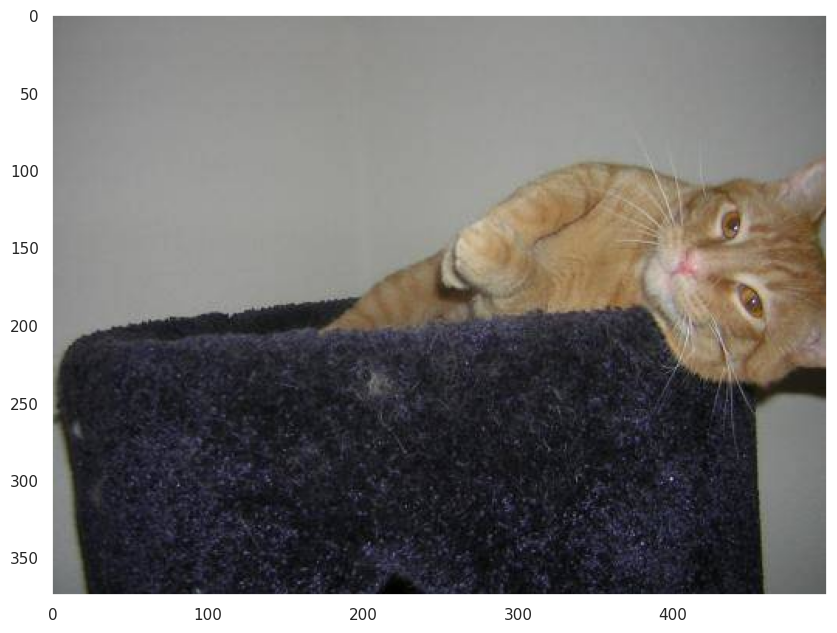

In [9]:
from tensorflow.keras.preprocessing import image

index = 232
img_path = '/content/cats_and_dogs/train/cats/cat.' \
            +str(index) + '.jpg'

img = image.load_img(img_path)
plt.figure(figsize = (10,10))
plt.imshow(img)
plt.grid(False)

Przyjrzenie się przykładowym obrazkom - psy



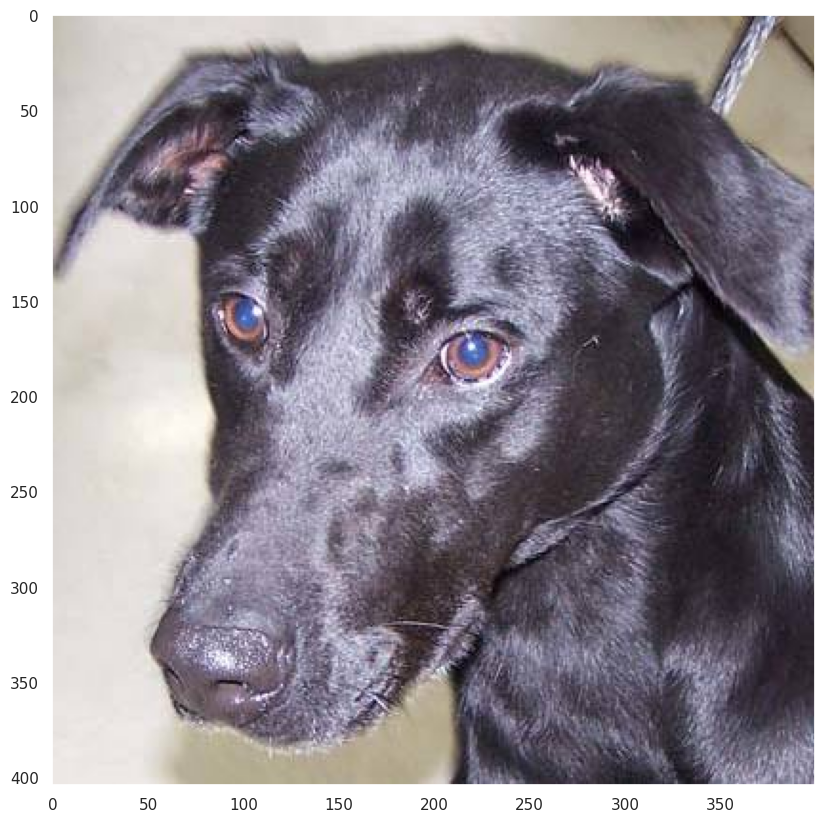

In [10]:
from tensorflow.keras.preprocessing import image

index = 242
img_path = '/content/cats_and_dogs/train/dogs/dog.' \
            +str(index) + '.jpg'

img = image.load_img(img_path)
plt.figure(figsize = (10,10))
plt.imshow(img)
plt.grid(False)

##Budowa modelu

Do budowy modelu wykorzystamy klasę Sequential biblioteki Keras. Pozwala ona dosyć wygodnie budować model niejako definiując kolejne warstwy tak, jakbyśmy układali je na stosie. Omówimy sobie krótko poszczególne warstwy.

Warstwa Conv2D jest warstwą konwolucji, w której należy podać minimum trzy parametry: liczbę filtrów,  dzięki którym będą wydobywane cechy, rozmiar jądra(wielkość okna konwolucji, zwyczajowo 3x3 lub 5x5) oraz funkcję aktywacji (najczęściej stosowana funkcja relu). Dodatkowo w pierwszej warstwie należy określić parametr input_shape, który przyjmuje rozmiar danych wejściowych. W naszym przypadku (150,150,3). Pierwsze dwie wartości określają szerokość i wysokość obrazka, trzeci natomiast głębie kolorów w tym przypadku 3.

Warstwa MaxPooling2D jest operacją skalowania. W dużym uproszczeniu polega na redukcji wymiarowości przechodząc po obrazie oknami ekstrakcji, które zwracają maksymalną zaobserwowaną wartość w danym oknie ( zwykle rozmiar okna 2x2, przy kroku przesunięcia równym 2) pomagając tym samym zmniejszyć rozmiar danych wejściowych do kolejnej warstwy o połowę, co znacząco przyśpiesza proces uczenia.

Warstwa Flatten wypłaszcza nam nasze dane w celu połączenia ich warstwami gęstymi pod koniec budowy modelu. Ostatnią funkcją aktywacji będzie funkcja sigmoid, która zwóri prawdopodobieństwo przynależności obrazka do poszczególnej klasy

In [11]:

from keras import models
from tensorflow.keras.layers  import Conv2D, MaxPooling2D, Flatten, Dense


model = models.Sequential()
model.add(Conv2D(filters = 32, kernel_size=(3,3), activation = 'relu', input_shape = (150, 150, 3) ))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(filters = 64, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(filters = 128, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(filters = 128, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Flatten())
model.add(Dense(units=512, activation = 'relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

Dzięki metodzie summary() możemy wyświetić szczegóły modelu. Model ma do wyuczenia w tym przypadku 3,453,121 parametrów, składa się z 11 warst (4 warstwy konwolucyjne, 4 warstwy MaxPooling, 1 warstwa Flatten i dwie warstwy gęste)

##Kompilacje modelu

Wykorzystamy dosyć powszechny optymalizator RMSprop przy funkcji straty entropii krzyżowej i metryce dokładności

In [12]:
from tensorflow.python import metrics
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])


#przetworzenie danych do modelu
Ponieważ nasze dane są nieustandaryzowane (różne rozmiary obrazów) musimy je przetworzyć, tak aby były przedstawione w formie tensorów wartości zmiennoprzecinkowych (float). Nasze dane są obecnie w postaci plików JPG. W procesie obróbki danych pomoże nam wbudowana w keras klasa ImageDataGenerator. Wszystkie obrazy ze zbioru treningowego i walidacyjnego przeskalujemy do rozmiaru 150x150 pikseli.




> W skrócie co zrobimy:



1.   Wczytamy pliki w formacie JPG
2.   Zdekodujemy format JPG do siadtki pikseli w formacie RGB
1.   Zapiszemy dane w formacie tensorów liczb zmiennoprzecinkowych
2.   Preskalujemy wartości pikseli do zakresu [0,1] (sieci neuronowe lepiej sobie radzą z małymi wartościami wejściowymi)y



In [13]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255.)
valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(directory = train_dir,  # generator danych treningowych
                                                    target_size= (150,150), #docelowy rozmiar zdjecia
                                                    batch_size= 20, #liczba próbek w jednej epoce
                                                    class_mode = 'binary') # problem binarnych

valid_generator = valid_datagen.flow_from_directory(directory= valid_dir,
                                                    target_size= (150,150),
                                                    batch_size = 20,
                                                    class_mode = 'binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#Sprawdzenie poprawności kształtu danych treningowych


In [14]:
for data_batch, labels_batch in train_generator:
    print('kształt danych wsadowych', data_batch.shape)
    print('kształt etykiet danych wsadowych', labels_batch.shape)

    break

kształt danych wsadowych (20, 150, 150, 3)
kształt etykiet danych wsadowych (20,)


#dopasowanie modelu
W celu przeprowadzenia trenowania na generatorze należy użyć metody fit_generator. Wytrenowany model zapiszemy do pliku cats_and_dogs_small_1.h5

In [15]:
import time

tic = time.time()

history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = 100,
                              epochs = 30,
                              validation_data = valid_generator,
                              validation_steps = 50
                             )
toc = time.time()
print('czas przetworzenia:{}'.format(toc-tic))
model.save('cats_and_dogs_small_1.h5')

Epoch 1/30
100/100 [==============================] - 21s 86ms/step - loss: 0.6886 - accuracy: 0.5275 - val_loss: 0.6805 - val_accuracy: 0.5470
Epoch 2/30
100/100 [==============================] - 5s 53ms/step - loss: 0.6601 - accuracy: 0.6100 - val_loss: 0.6499 - val_accuracy: 0.6170
Epoch 3/30
100/100 [==============================] - 6s 62ms/step - loss: 0.6080 - accuracy: 0.6690 - val_loss: 0.6325 - val_accuracy: 0.6240
Epoch 4/30
100/100 [==============================] - 7s 65ms/step - loss: 0.5594 - accuracy: 0.7075 - val_loss: 0.6277 - val_accuracy: 0.6540
Epoch 5/30
100/100 [==============================] - 5s 53ms/step - loss: 0.5339 - accuracy: 0.7255 - val_loss: 0.5821 - val_accuracy: 0.6830
Epoch 6/30
100/100 [==============================] - 5s 52ms/step - loss: 0.5034 - accuracy: 0.7500 - val_loss: 0.5842 - val_accuracy: 0.6900
Epoch 7/30
100/100 [==============================] - 6s 64ms/step - loss: 0.4743 - accuracy: 0.7730 - val_loss: 0.5834 - val_accuracy: 0.682

#wykres dokładności trenowania i walidacji

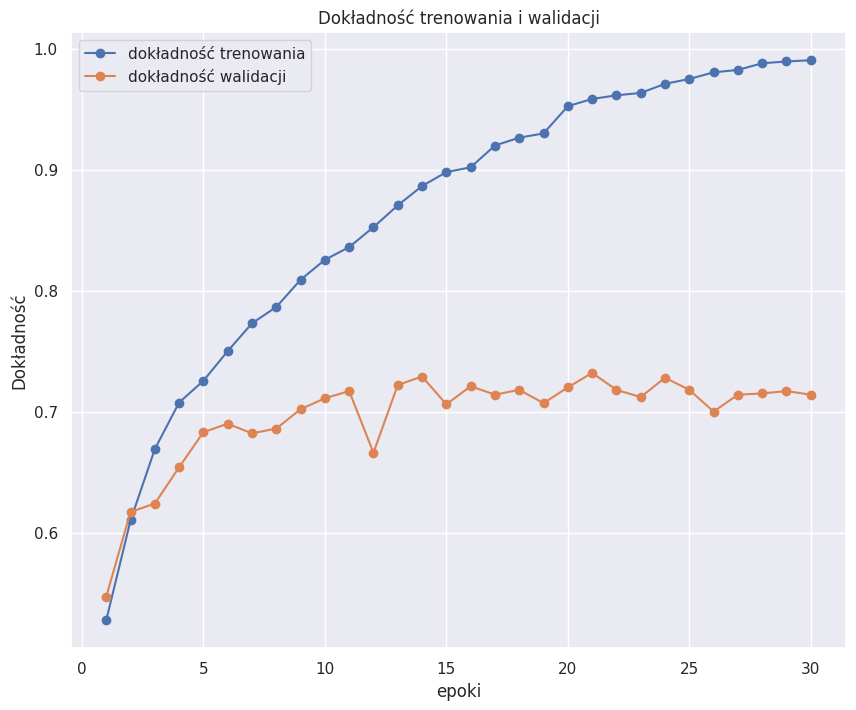

In [16]:
make_accuracy_plot(history)

#Wykres straty trenowania i walidacji

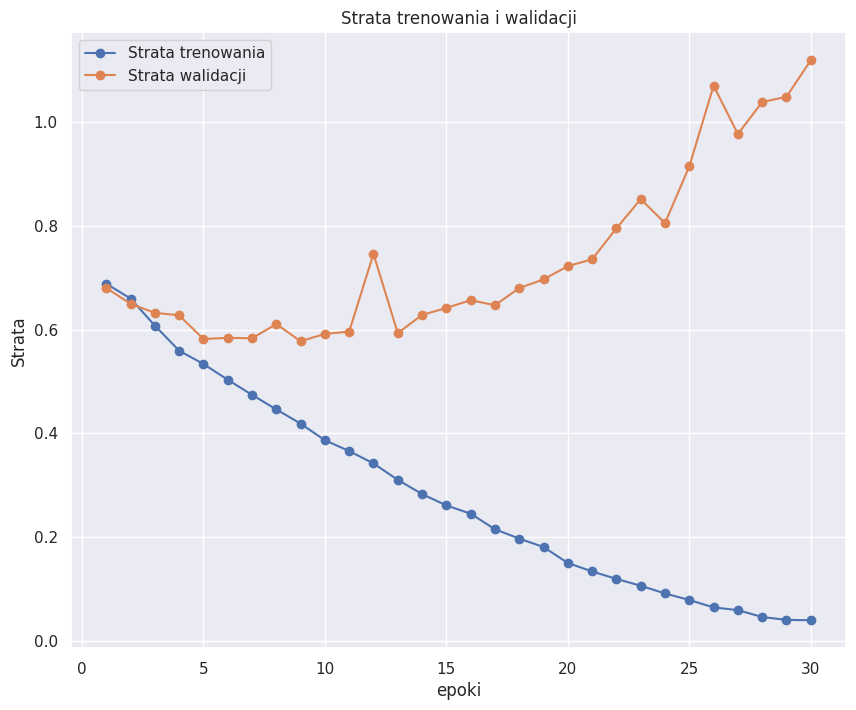

In [17]:
make_loss_plot(history)

Przy około 10 epoce strata zaczyna wzrastać co oznacza że w 10 epoce należy zaprzestać ponieważ ulega przetrenowaniu. Osiąga wówczas dokładność na poziomie około 73%. Wynik nie jest zadowalający i postaramm sie poprawić model



##Augmentacja danych
Technika ta jest przydatna w przypadku niewystarczającej ilości danych treningowych. Polega ona na różnych przekształceniach naszych danych wejściowych poprzez takie operacje jak przyciamie, obrót czy powiększanie w celu wygenerowania nowych daych wejściowch (nowych obrazków)



In [18]:
datagen = ImageDataGenerator(rotation_range=40,#zakres kąta o który losowo zostanie wykonany obrót obrazów
                             width_shift_range=0.2,#pionowe przekształcenie obrazu
                             height_shift_range=0.2,#poziome przekształcenie obrazu
                             shear_range=0.2,#zakres losowego przycinania obrazu
                             zoom_range=0.2,#zakres losowego przycinania obrazi
                             horizontal_flip=True,#losowe odbicie obrazu w płaszczyznie poziomej
                             fill_mode='nearest') #strategia wypełnianiania nowo utworzonych pikseli

##Wyświetlanie kilku przykładów augmentacji - koty

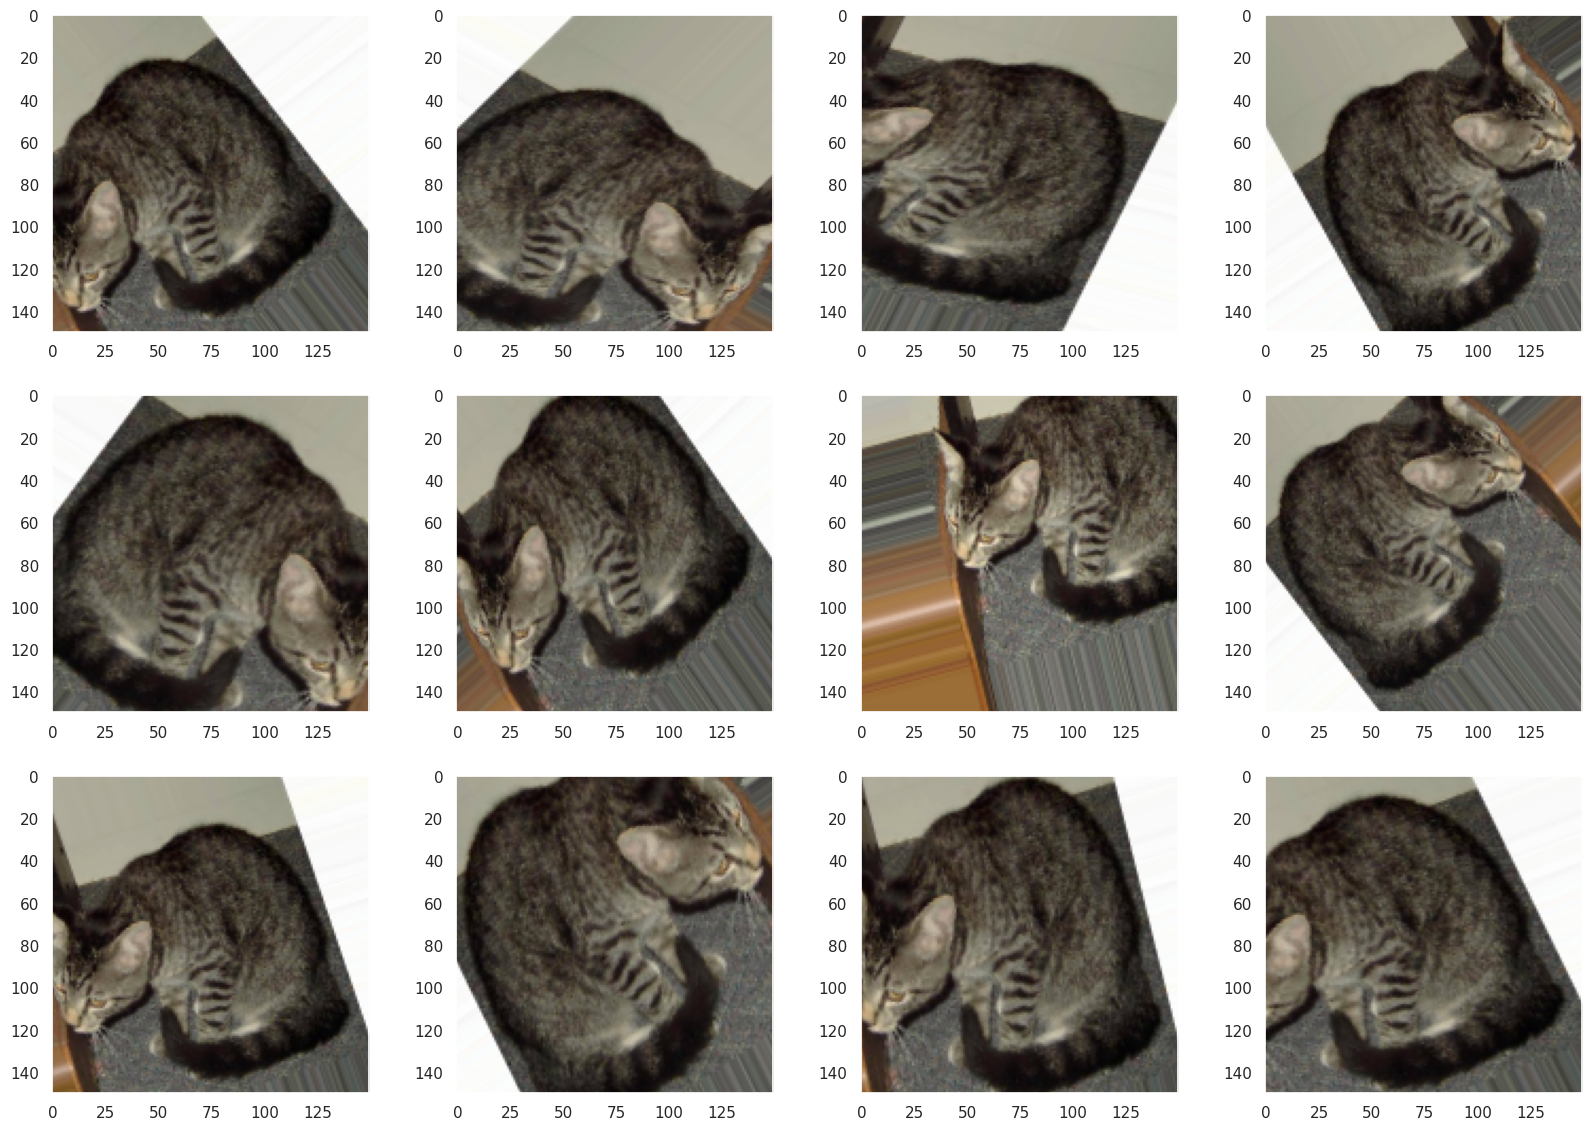

In [19]:

import keras.utils as image

index = 326
display_augmented_images(train_cats_dir, index)

##Wyświetlanie kilku przykładów augmentacji - psy

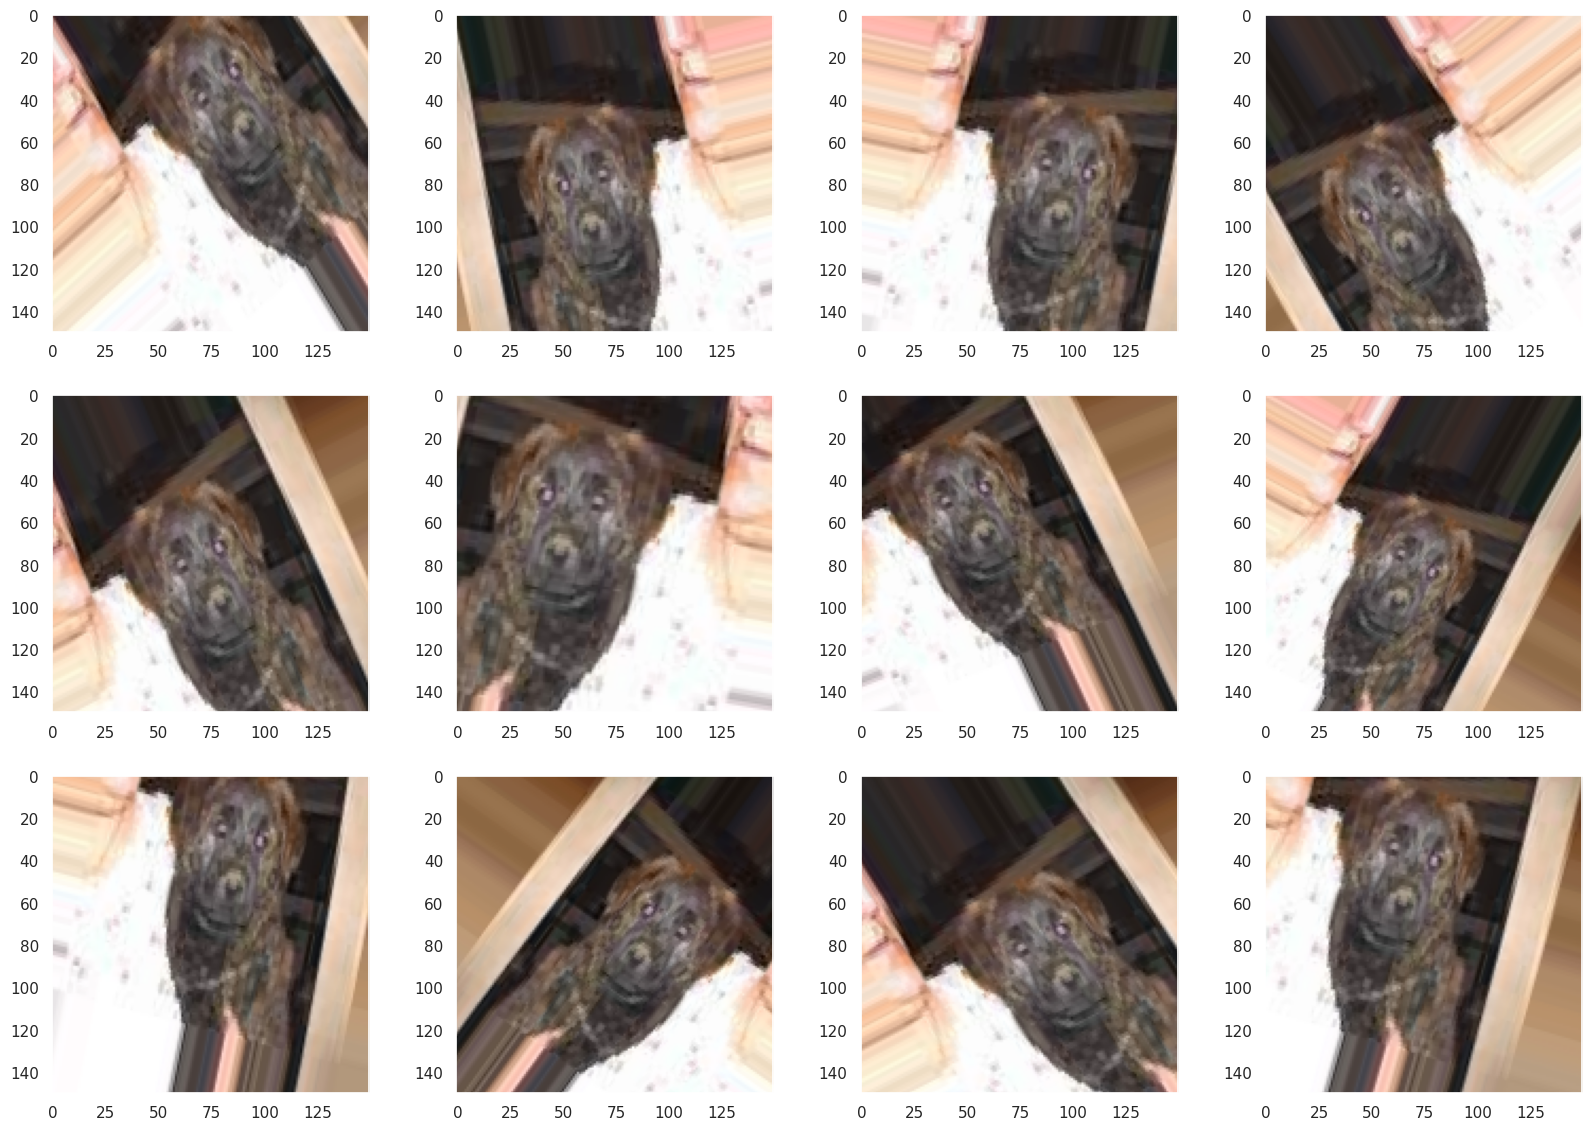

In [20]:

import keras.utils as image

index = 326
display_augmented_images(train_dogs_dir, index)

#Trenowanie konwolucyjnej sieci neuronowej z wykorzystaniem obrazów wygenerowanych za pomocą augmentacji danych

In [35]:

from tensorflow.keras.layers  import  Dropout

model = models.Sequential()
model.add(Conv2D(filters = 32, kernel_size=(3,3), activation = 'relu', input_shape = (150, 150, 3) ))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(filters = 64, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(filters = 128, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(filters = 128, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=512, activation = 'relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()


model.compile(optimizer='rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 128)     

In [42]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
#niemodyfikujemy danych walidacyjnych!!!
valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(directory = train_dir,  # generator danych treningowych
                                                    target_size= (150,150), #docelowy rozmiar zdjecia
                                                    batch_size= 32, #liczba próbek w jednej epoce
                                                    class_mode = 'binary') # problem binarnych

valid_generator = valid_datagen.flow_from_directory(directory= valid_dir,
                                                    target_size= (150,150),
                                                    batch_size = 32,
                                                    class_mode = 'binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [45]:
history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = 62,
                              epochs = 100,
                              validation_data = valid_generator,
                              validation_steps =10
                             )


Epoch 1/100
62/62 [==============================] - 15s 234ms/step - loss: 0.3231 - accuracy: 0.8669 - val_loss: 0.2860 - val_accuracy: 0.8844
Epoch 2/100
62/62 [==============================] - 15s 237ms/step - loss: 0.2963 - accuracy: 0.8780 - val_loss: 0.2919 - val_accuracy: 0.8500
Epoch 3/100
62/62 [==============================] - 15s 241ms/step - loss: 0.2821 - accuracy: 0.8857 - val_loss: 0.3352 - val_accuracy: 0.8750
Epoch 4/100
62/62 [==============================] - 16s 254ms/step - loss: 0.2832 - accuracy: 0.8786 - val_loss: 0.5949 - val_accuracy: 0.8094
Epoch 5/100
62/62 [==============================] - 15s 243ms/step - loss: 0.2861 - accuracy: 0.8765 - val_loss: 0.4151 - val_accuracy: 0.8375
Epoch 6/100
62/62 [==============================] - 15s 250ms/step - loss: 0.2700 - accuracy: 0.8902 - val_loss: 0.2947 - val_accuracy: 0.8656
Epoch 7/100
62/62 [==============================] - 16s 257ms/step - loss: 0.2805 - accuracy: 0.8811 - val_loss: 0.3070 - val_accuracy:

In [46]:
model.save('cats_and_dogs_small_2.h5')

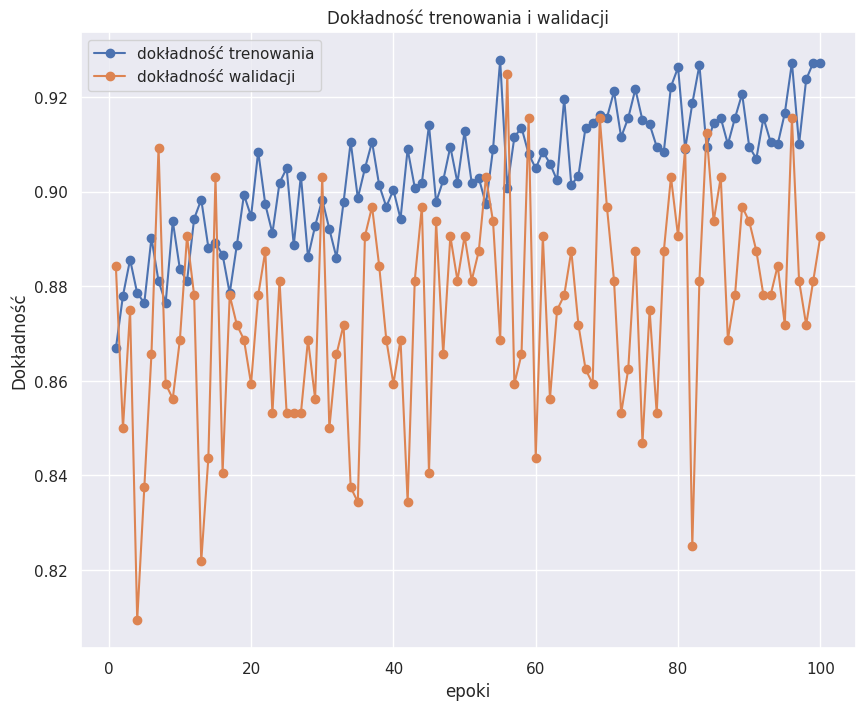

In [47]:
make_accuracy_plot(history)

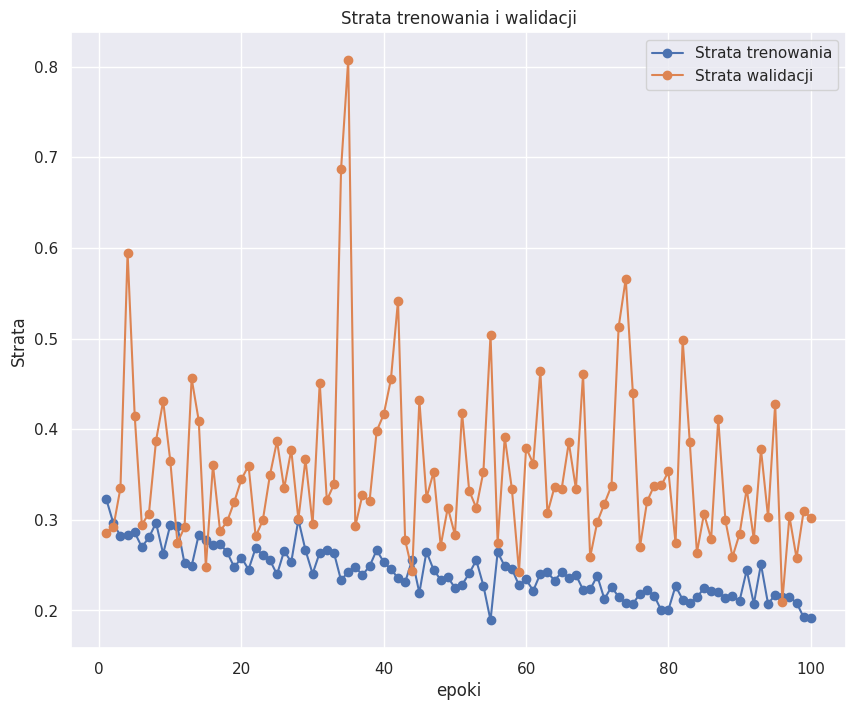

In [48]:
make_loss_plot(history)

Model bardzo niestabilny, trzeba go naprawić